In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Makes predictions with an ONNX model

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import v2

import onnx
import onnxruntime as ort

from dataset import WaterLevelDataset, collate_fn
from plots import decode_yolov11_segmentation, visualize_image_with_mask
from plots import visualize_images_with_masks

In [4]:
#
# definitions
#
imgsz = 640  # the default on train.py
batch_size = 5
onnx_model_path = "../runs/segment/yolo11l-seg-300ep/weights/best.onnx"
config_file = "../water.yaml"

# need to resize the image to the size used on training
transform = v2.Compose([
    v2.Resize([imgsz, imgsz]),  # we need to resize both h and w
    v2.ToTensor()
])

/opt/conda/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
# Dataset
dataset = WaterLevelDataset(config_path=config_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn) 

image, labels = dataset[10]
image.shape

torch.Size([3, 640, 640])

In [6]:
print(f"Loading {onnx_model_path}")
model = onnx.load(onnx_model_path)
onnx.checker.check_model(model)

ort_sess = ort.InferenceSession(onnx_model_path)
output = ort_sess.run(None, {'images': np.expand_dims(image.numpy(), 0)})

2025-10-14 13:59:21.346003310 [E:onnxruntime:Default, env.cc:226 ThreadMain] pthread_setaffinity_np failed for thread: 55675, index: 0, mask: {1, 21, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.


Loading ../runs/segment/yolo11l-seg-300ep/weights/best.onnx


2025-10-14 13:59:21.352586261 [E:onnxruntime:Default, env.cc:226 ThreadMain] pthread_setaffinity_np failed for thread: 55685, index: 10, mask: {11, 31, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-10-14 13:59:21.360514193 [E:onnxruntime:Default, env.cc:226 ThreadMain] pthread_setaffinity_np failed for thread: 55684, index: 9, mask: {10, 30, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-10-14 13:59:21.362682461 [E:onnxruntime:Default, env.cc:226 ThreadMain] pthread_setaffinity_np failed for thread: 55676, index: 1, mask: {2, 22, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-10-14 13:59:21.364516500 [E:onnxruntime:Default, env.cc:226 ThreadMain] pthread_setaffinity_np failed for thread: 55683, index: 8, mask: {9, 29, }, error code: 22 error msg: Invalid argument. Sp

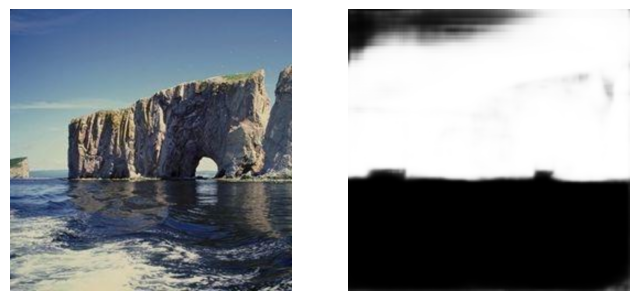

In [7]:
image_np = image.permute(1, 2, 0).cpu().numpy()
boxes, masks = decode_yolov11_segmentation(output, conf_thresh=0.5, image_size=(640, 640))

visualize_image_with_mask(image_np, boxes, masks)

## predict from dataloader

In [8]:
images, labels = next(iter(dataloader))
images_np = []
outputs = []
for idx in range(images.shape[0]):
    image = images[idx]
    output = ort_sess.run(None, {'images': np.expand_dims(image.numpy(), 0)})
    boxes, masks = decode_yolov11_segmentation(output, conf_thresh=0.5, image_size=(640, 640))

    image_np = image.permute(1, 2, 0).cpu().numpy()
    images_np.append(image_np)
    outputs.append([boxes, masks])

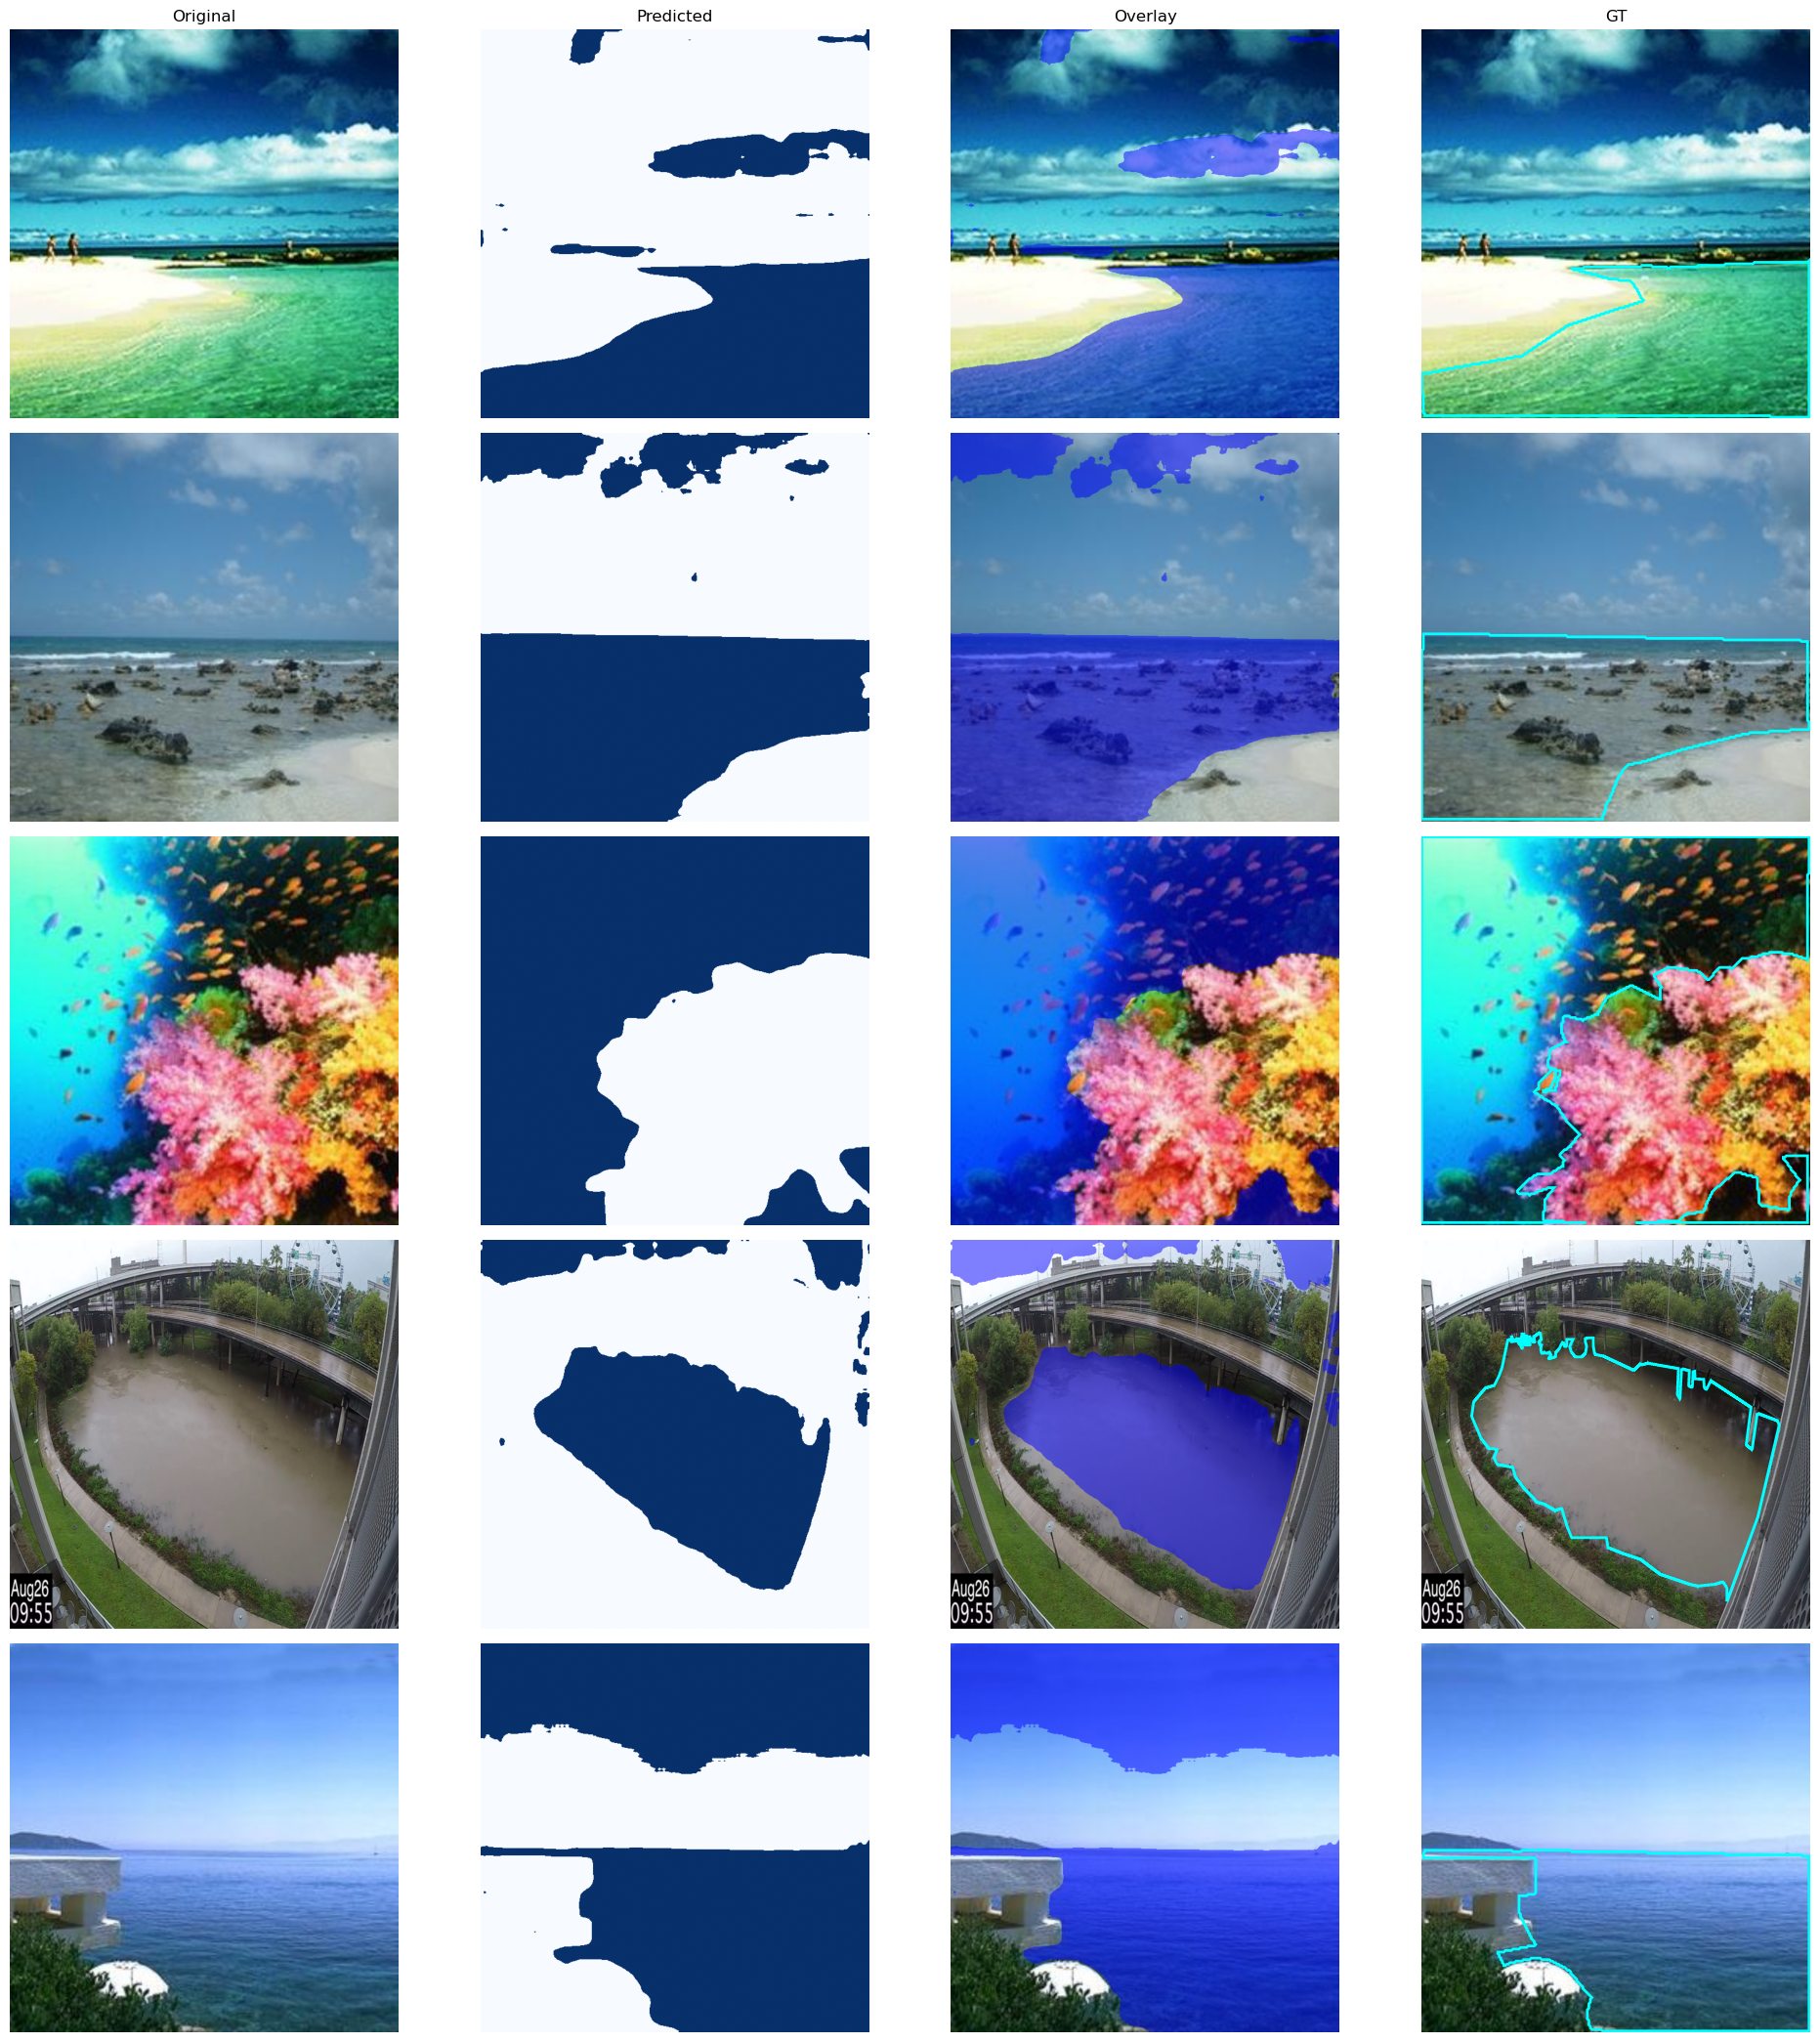

In [9]:
visualize_images_with_masks(images_np, outputs, labels)